[New features baseline training](#New-features)

[New hyperparameter trainings](#New-hyperparameters)

[Low and high level variables training](#Low-and-high-level-features)

In [1]:
import os
import sys
import inspect
import datetime
from time import time
from importlib import reload  
import pandas as pd
import numpy as np
import tables
import h5py
from joblib import load, dump
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import json

In [2]:
sys.path.append('/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning')

In [3]:
import HpTrainingFrame
from HpMLWeightTransformer import MultiSBWeightsScaler, WeightsMultiplier
from HpMLMTL import HpMTLBackgroundAugmenter, HpMTLBackgroundRandomizer
from HpMLUtils import FeatureDivider,variance
from HpMLFeatureNormalisation import WeightedStandardScaler
import HpKerasUtils
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint 
from sklearn.metrics import roc_auc_score, roc_curve

In [7]:
reload(HpTrainingFrame)

<module 'HpTrainingFrame' from '/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/HpTrainingFrame.py'>

# Functions definition

In this section two functions will be defined, one for preparing the data for training and another one for the training itself.

In [2]:
def label_discr (row):
    ''' Function to filter hpdiscriminant value by mass'''
    if(row.hpmass<0): 
        return row['HpDiscriminant_'+str(-int(row.hpmass))]
    else: 
        return row['HpDiscriminant_'+str(int(row.hpmass))]

def PrepareMassParametrised(df, feature_names, hpmass='multi', region="INC_ge6jge4b", steps_names=['msb','scl','rnd','fd','wss'], onediscr=True, exclude_columns=['nJets','nBTags_70']):
    """Prepares data for training. It can be selected which modifications will be done to the data:
        msb: MultiSBWeightsScaler
        scl: WeightsMultiplayer
        aug: HpMTLBackgroundAugmenter
        rnd: HpMTLBackgroundRandomizer
        fd: FeatureDivider
        wss: WeightStandardScaler
        Returns 9 data frames corresponding to train, test and data evaluation"""
    
    #WeightsMultiplier scale for multiple mass NN
    scales={
      200:16.,
      225:8.,
      250:8.,
      275:8.,
      300:16./3.,
      350:4.,
      400:8./3.,
      500:2.,
      600:2.,
      700:2.,
      800:2.,
      900:2.,
      1000:4./3.,
      1200:1.,
      1400:1.,
      1600:1.2,
      1800:1.5,
      2000:4.,
    }
    
    discr = ['HpDiscriminant_200','HpDiscriminant_225','HpDiscriminant_250','HpDiscriminant_275','HpDiscriminant_300','HpDiscriminant_350','HpDiscriminant_400','HpDiscriminant_500','HpDiscriminant_600','HpDiscriminant_700','HpDiscriminant_800','HpDiscriminant_900','HpDiscriminant_1000','HpDiscriminant_1200','HpDiscriminant_1400','HpDiscriminant_1600','HpDiscriminant_1800','HpDiscriminant_2000']
    
    htf = HpTrainingFrame.HpTrainingFrame(df,feature_names + discr)
    msb = MultiSBWeightsScaler(backgroundclass=-1)
    scl = WeightsMultiplier(scales=scales,backgroundclass=-1)
    aug = HpMTLBackgroundAugmenter(backgroundclass=-1)
    rnd = HpMTLBackgroundRandomizer(backgroundclass=-1)
    fd = FeatureDivider("hpmass",excludecolumns = exclude_columns)
    wss = WeightedStandardScaler()
        
    steps=[(msb,"msb"),(scl,"scl"),(aug,"aug"),(rnd,"rnd"),(fd,"fd"),(wss,"wss")]
        
    #Divide data in three data frames, one for data, second for labels and third for weights
    X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=hpmass,region=region,addMass=True)
    y_train = X_train.hpmass.copy()
    y_test = X_test.hpmass.copy()
      
    #Processing data and preparing it for training. Only chosen modifications will be done
    for hp_class, class_name in steps:
        if class_name in steps_names:

            hp_class.fit(X_train,X_train.hpmass, sample_weight=w_train)
            X_train, y_train, w_train = hp_class.transform(X_train,y_train, sample_weight=w_train)
            X_test, y_test, w_test = hp_class.transform(X_test,y_test, sample_weight=w_test)
            
            if class_name=='rnd' and onediscr==True:
                #Remove the discriminant
                for imass in list(X_train.hpmass.unique()):
                    X_train.loc[X_train.hpmass == imass,'HpDiscriminant'] = X_train[X_train.hpmass == imass]['HpDiscriminant_'+str(imass)]
                    X_test.loc[X_test.hpmass == imass,'HpDiscriminant'] = X_test[X_test.hpmass == imass]['HpDiscriminant_'+str(imass)]
#                X_train['HpDiscriminant'] = X_train.apply(lambda row: label_discr(row), axis=1)
#                X_test['HpDiscriminant'] = X_test.apply(lambda row: label_discr(row), axis=1)
                
                X_train = X_train.drop(columns=discr)
                X_test = X_test.drop(columns=discr)            
                #Move the mass column to the last
                cols = list(X_train.columns)
                cols[-2:] = cols[:-3:-1]
                X_train = X_train[cols]
                X_test = X_test[cols]

            #Printing background and signal integral. Just to clarify how weights change in every process
            print(class_name + ":")
            print("Background integral:",w_train.values[y_train<0].sum(),"\nSignal integral:",w_train.values[y_train>0].sum(),'\n')
            
                
    y_train=(y_train>0)
    y_test=(y_test>0)
    
    if 'wss' in steps_names: return [(X_train, y_train, w_train),(X_test, y_test, w_test),(wss.mean_,wss.scale_)]
    else: return [(X_train, y_train, w_train),(X_test, y_test, w_test),(None,None)]

In [3]:
def getCallbacks(model):
    """ Standard callbacks for Keras Early stopping and checkpoint"""
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath='model_nn_'+str(model.configuration)+"_dropout"+str(model.dropout)+"_l2threshold"+str(model.l2threshold)+".hdf5",
                        monitor='val_loss',
                        save_best_only=True)  
    ]


def training(training_data,test_data,configuration,dropout,epochs,patience,batch_size,trainlabel,region):
    """Training function"""
    
    #Keeping track of when the training started
    training_start = int(time())
    start_hour = datetime.datetime.now().strftime("%H:%M:%S")
    
    #Standard feedforward model
    modelNN = HpKerasUtils.HpFeedForwardModel(configuration,dropout=dropout, verbose=True, input_dim=X_train.shape[1])
    resultNN = modelNN.train(training_data, test_data,
                             patience=patience , epochs=epochs, callbacks=getCallbacks(modelNN), batch_size=batch_size)
    
    #Keeping track of when the training finished. Getting the training time
    training_finish = int(time())
    finish_hour = datetime.datetime.now().strftime("%H:%M:%S")
    dif_time = training_finish-training_start
    print('Start hour:'+start_hour+'\n'+'Finish hour:'+finish_hour+'\n'+'Training time:'+str(datetime.timedelta(seconds=dif_time)))
    
    #Saving raw NN model
    #dump(modelNN,'NN_sergio_results/massparameterisedNN_'+ region +'_'+ trainlabel + '.joblib')
    
    #Printing training results and plotting binary accuracy and loss
    print(resultNN)
    modelNN.plotTrainingValidation()
    
    return modelNN

In [4]:
def ROC_Score_plot(modelNN,X,y,w,path,reg,plotlabel,do_ROC=True,do_Score=True,hpmass=None):
    """Function that plots ROC curve and NN socore for the test data
       on Matplotlib"""
    
    #Getting the data we want to plot
    y_pred = modelNN.model.predict(X.values).ravel()
    roc_auc = roc_auc_score(y,y_pred,sample_weight=w)
    false_pr, true_pr, thresholds = roc_curve(y, y_pred, sample_weight = w)
    
    if do_ROC==True:
        #Plotting ROC
        plt.figure(figsize=(6.4,4.8),linewidth=0)

        plt.plot(false_pr,true_pr, ls='-', c="blue", linewidth=1.3, label="ROC (area = {:.5f})".format(roc_auc))
        plt.plot([0.,1.],[0.,1.], ls='--', c="gray", linewidth=1.3, label="Luck")

        plt.xlabel("False Positive Rate", ha="right",x=1, fontsize=10.3, labelpad=10)
        plt.ylabel("True Positive Rate",ha= "right",y=1, fontsize=11, labelpad=10)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
        plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

        plt.xlim(-.05,1.05)
        plt.ylim(-.05, 1.05)

        plt.legend(loc="best", frameon=True, prop=fm.FontProperties(fname=fpath,size=11))
        
        if hpmass==None: plt.savefig(path + '/roc_curve_' + reg + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
        else: plt.savefig(path + '/roc_curve_' + reg + '_' + str(hpmass) + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
        plt.show
    
    if do_Score==True:
        #Plotting Score
        plt.figure(figsize=(6.4,4.8),linewidth=0)

        plt.hist(y_pred[y<0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w[y<0.5], fc=(0.,0.,1.,0.18), ec="blue", linewidth=1.3, density=True, label="Background")
        plt.hist(y_pred[y>0.5], bins=50, range=(0,1), histtype="stepfilled", weights=w[y>0.5], fc=(1.,0.,0.,0.18), ec="red", linewidth=1.3, density=True, label="H$^+$mass={} GeV".format(hpmass)\
                 if hpmass!= None else 'Signal')

        plt.xlabel("Mass Parameterised NN Score", ha="right",x=1, fontsize=10.3, labelpad=10)

        plt.minorticks_on()
        plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
        plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)

        plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
        plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

        plt.xlim(-.05,1.05)
        plt.ylim(0, plt.gca().get_ylim()[1]*1.15 )

        plt.legend(loc="best", frameon=False, prop=fm.FontProperties(fname=fpath,size=11))
        
        # Print AUC at the corner
        ax = plt.gca()
        plt.text(0.15,0.93,'AUC = {:.5f}'.format(roc_auc), horizontalalignment='center', verticalalignment='center',\
                 transform = ax.transAxes,fontproperties=fm.FontProperties(fname=fpath,size=11))

        if hpmass==None: plt.savefig(path + '/NN_Score_' + reg + '_' + plotlabel + '.png',dpi=300,bbox_inches='tight')
        else: plt.savefig(path + '/NN_Score_' + reg + '_' + str(hpmass) + '_' + plotlabel + '.png',dpi=300,bbox_inches='tight')
        plt.show
        
    return roc_auc

        
def AUCvsHpmass(rocs,mass,reg,path,plotlabel):
    plt.figure(figsize=(6.4,4.8),linewidth=0)

    plt.plot(mass,rocs, ls='-', c="blue", marker='o', linewidth=1.3)
    plt.plot([0.,2400.],[1.,1.], ls='--', c="gray", linewidth=1.3)

    plt.xlabel("H$^+$ mass [GeV]", ha="right",x=1, fontsize=10.3, labelpad=10)
    plt.ylabel("AUC",ha= "right",y=1, fontsize=11, labelpad=10)

    plt.minorticks_on()
    plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
    plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)

    plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
    plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

    plt.xlim(0,2200)
    plt.ylim(0.6, 1.02)

    plt.savefig(path + '/aucvsmass_' + reg + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
    plt.show

def relativeAUC(aucs,auc_file_name,reg,path,plotlabel):
    
    with open(auc_file_name,'r') as inputFile:
        data = json.load(inputFile)
        mass = data['Hp mass']
        old_auc = data['AUC']
        
    plt.figure(figsize=(6.4,4.8),linewidth=0)

    plt.plot(mass,-(aucs-old_auc)/old_auc, c="blue", marker='o', ls='None')

    plt.xlabel("H$^+$ mass [GeV]", ha="right",x=1, fontsize=10.3, labelpad=10)
    plt.ylabel("AUC realtive difference",ha= "right",y=1, fontsize=11, labelpad=10)

    plt.minorticks_on()
    plt.tick_params(axis="both", which="major", width=.6, length=7.5, pad=4)
    plt.tick_params(axis="both", which="minor", width=.6, length=4, pad=4)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    plt.xticks(fontproperties=fm.FontProperties(fname=fpath,size=11))
    plt.yticks(fontproperties=fm.FontProperties(fname=fpath,size=11))

    plt.xlim(0,2200)
#    plt.ylim(-0.1e-2, 2.5e-2)

    plt.savefig(path + '/relativeauc_' + reg + '_' + plotlabel +'.png',dpi=300,bbox_inches='tight')
    plt.show

# Runner

## New features

In [2]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_e1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_e2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_e3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_e4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_e5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_e6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','lepton_e']
steps = ['msb','scl','rnd','wss']
region = "INC_ge6jge4b"
NNlayers = [64,64]
batchsize = 50
dropout = 0.1
epochs = 300
patience = 5

In [3]:
df_new = pd.read_hdf("/nfs/at3/scratch/salvador/HplusML/HDFWriter/pandas_4vec/pandas_INC_ge6jgeq4b.h5")
df_new = df_new[(df_new.process!='Hp1001')&(df_new.process!='ttlight_aMCNloP8')&(df_new.process!='tH_new')&(df_new.weight!=0)&(df_new.hpmass!=2500)&(df_new.hpmass!=3000)]
df_new.head()

,index,dRlepbb_MindR_70,jet_eta,HpDiscriminant_275,HpNNv3_350,HpNNv3_600,HpDiscriminant_225,mu_eta,Muu_MindR_70,Mbb_MaxM_70,...,Centrality_all,HpNNv3_250,weight,ReWeighting,process,group,region,tagWeightBin_MV2c10_Continuous,hpmass,year
0,0,1.632954,"[-0.61083865, -0.38421518, 1.0957781, 0.209408...",0.628027,0.464503,0.458725,0.473889,[0.66914076],168296.703125,231522.750000,...,0.739273,0.436460,0.062751,1.017244,ttlight,t#bar{t} + light,INC_ge6jge4b,"[1, 4, 5, 4, 2, 4]",-1,mc16a
1,1,2.318960,"[-0.6561383, -0.13251838, -0.52890044, -0.1273...",0.677458,0.695016,0.305937,0.316257,[],57218.773438,200162.296875,...,0.852112,0.681223,0.136305,0.996082,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 5, 4, 4, 1, 1]",-1,mc16a
2,2,0.870068,"[2.381791, -1.3918624, 1.8041257, -1.0344955, ...",0.016884,0.098823,0.099795,0.092083,[-0.25464767],110607.484375,333937.500000,...,0.362028,0.191971,0.108638,1.010369,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 4, 1, 5, 4]",-1,mc16a
3,3,3.142407,"[0.9403318, 1.4658026, -0.07202754, 0.48571306...",0.621517,0.356497,0.042438,0.664618,[],65231.687500,186417.437500,...,0.654665,0.563828,0.112889,1.029358,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 4, 5, 4, 1]",-1,mc16a
4,4,2.089809,"[1.0356635, 2.0446057, -2.070395, 0.088136375,...",0.432156,0.172446,0.021674,0.574934,[1.4766937],448008.250000,130885.703125,...,0.388816,0.330892,0.122123,1.118524,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 1, 5, 4, 5]",-1,mc16a


In [4]:
columns_suffix= ['pt','eta','phi','e']

for s in columns_suffix:
    df_new['el_'+s]=pd.DataFrame(df_new['el_'+s].tolist(), index= df_new.index)
    df_new['mu_'+s]=pd.DataFrame(df_new['mu_'+s].tolist(), index= df_new.index)
    df_new.loc[np.isnan(df_new['el_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['el_'+s])==False]['el_'+s]
    df_new.loc[np.isnan(df_new['mu_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['mu_'+s])==False]['mu_'+s]

In [5]:
#There are some events with more than 6 components on jet_e, we cut the extra components
def jet_e_components(row):    
    ''' Function to get only the first 6 components of jet_e lists'''
    if len(row.jet_e)>6: 
        return row['jet_e'][:6]
    else: 
        return row['jet_e']
    
df_new['jet_e'] = df_new.apply (lambda row: jet_e_components(row), axis=1)

In [8]:
%%time
htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
df_no_vectors = htf.load_vec_features()

['jet_pt1', 'jet_pt2', 'jet_pt3', 'jet_pt4', 'jet_pt5', 'jet_pt6']
['jet_eta1', 'jet_eta2', 'jet_eta3', 'jet_eta4', 'jet_eta5', 'jet_eta6']
['jet_phi1', 'jet_phi2', 'jet_phi3', 'jet_phi4', 'jet_phi5', 'jet_phi6']
['jet_e1', 'jet_e2', 'jet_e3', 'jet_e4', 'jet_e5', 'jet_e6']
['jet_mv2c101', 'jet_mv2c102', 'jet_mv2c103', 'jet_mv2c104', 'jet_mv2c105', 'jet_mv2c106']
CPU times: user 36.8 s, sys: 10.1 s, total: 46.9 s
Wall time: 46.9 s


In [14]:
%%time
htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names)
df_no_vectors = htf.load_vec_features1()

CPU times: user 2min 47s, sys: 17.5 s, total: 3min 4s
Wall time: 3min 4s


In [9]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

msb:
Background integral: 0.5 
Signal integral: 0.5 

scl:
Background integral: 0.5 
Signal integral: 0.5 

-1 1134182    3.564395e-08
63564      1.238117e-06
1376655    4.716239e-08
1116034    1.178930e-11
85513      6.783175e-07
               ...     
773653     6.509096e-07
1650183    1.653604e-07
1401201    1.947045e-08
1591320    5.042264e-08
1014801    5.554679e-07
Name: weight, Length: 973135, dtype: float64 0.5
200 1949727    0.000015
1952077    0.000011
1948948    0.000018
1949156    0.000019
1950513    0.000021
             ...   
1951659    0.000016
1951691    0.000028
1948311    0.000017
1950098    0.000018
1949061    0.000018
Name: weight, Length: 2100, dtype: float64 0.04405286343612336
225 1957651    3.388339e-06
1957494    7.660917e-06
1958522    4.776432e-06
1957951    7.743244e-06
1955832    5.695298e-06
               ...     
1954153    4.811665e-06
1956217    5.900147e-06
1956961    6.349497e-06
1958917    4.241294e-06
1958085    5.291226e-09
Name: weight, Length:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2368      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,593
Trainable params: 6,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21740/21740 [==============================] - 108s 5ms/step - loss: 4.4097e-07 - binary_accuracy: 0.7103 - 

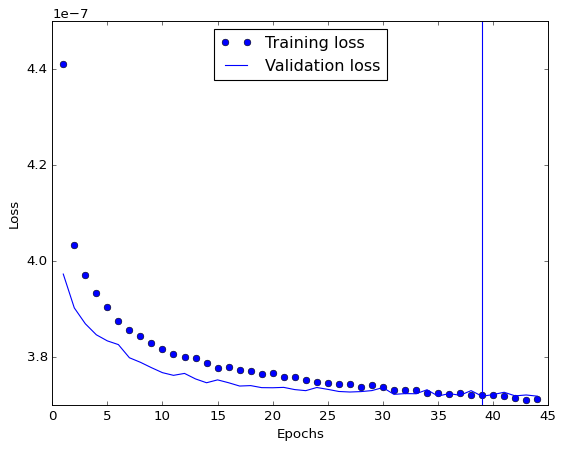

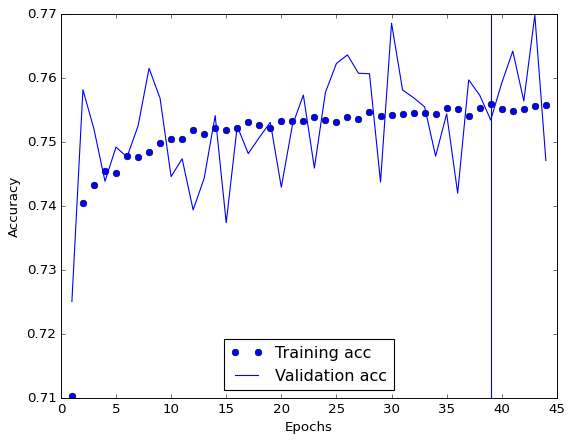

In [10]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'4vec_features',region)

0.8903172981590356

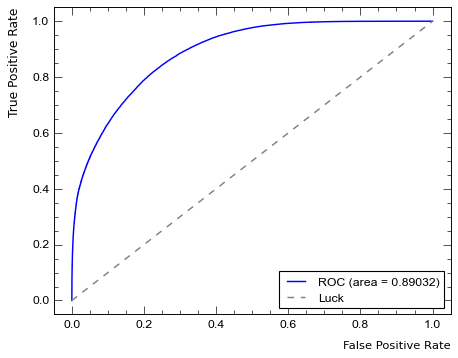

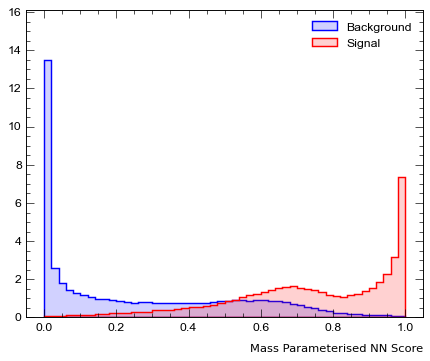

In [11]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'4vec_features')

(977067, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(978810, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980083, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980617, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981324, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980383, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980821, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(980204, 36) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
(981081,

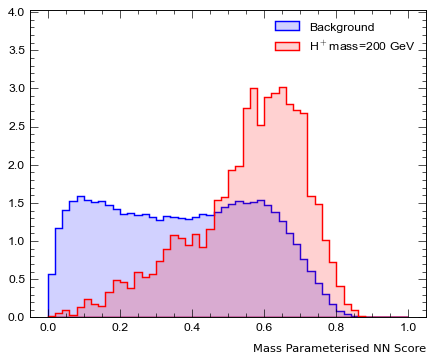

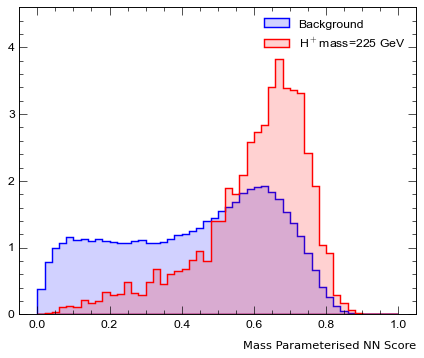

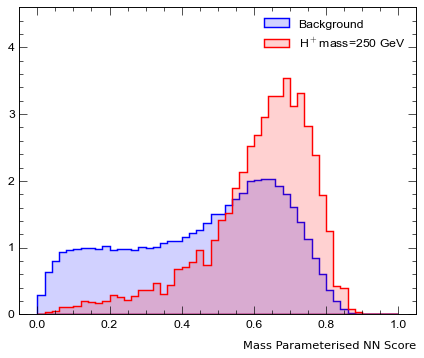

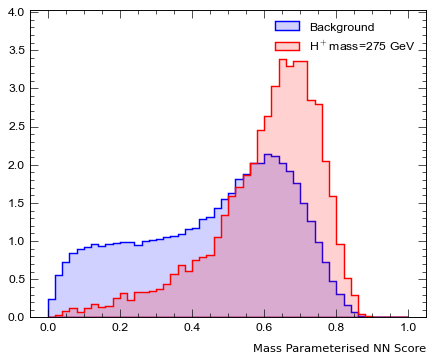

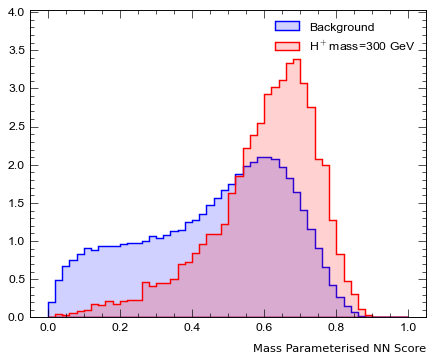

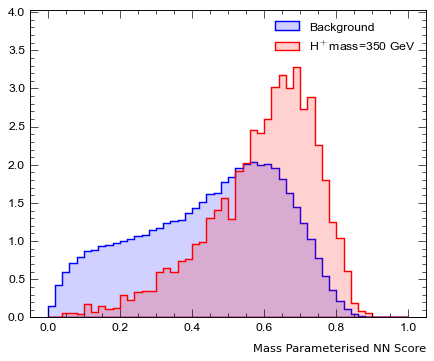

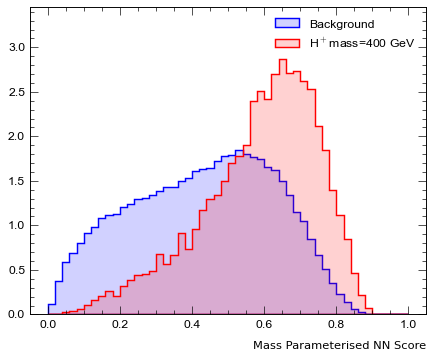

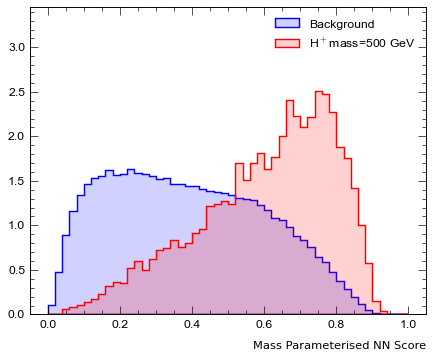

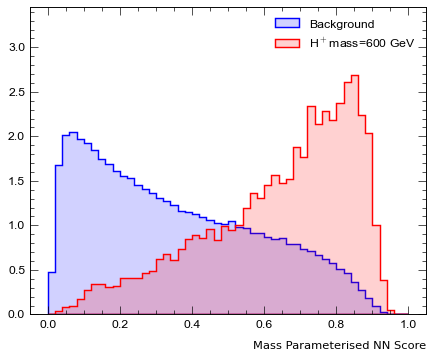

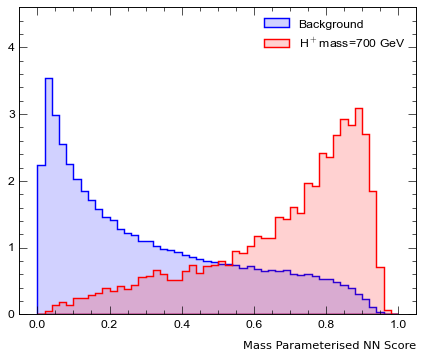

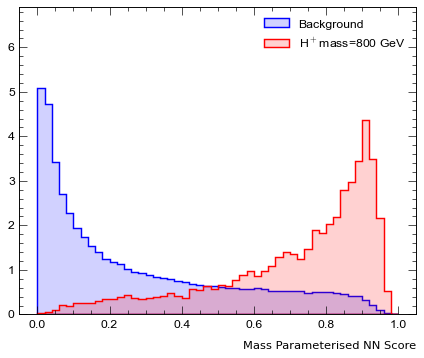

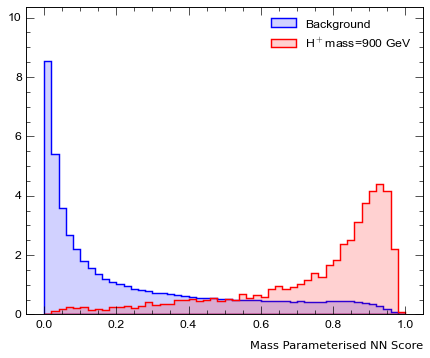

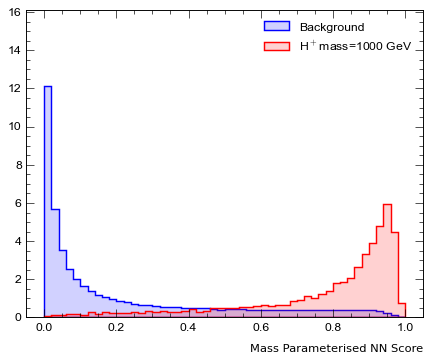

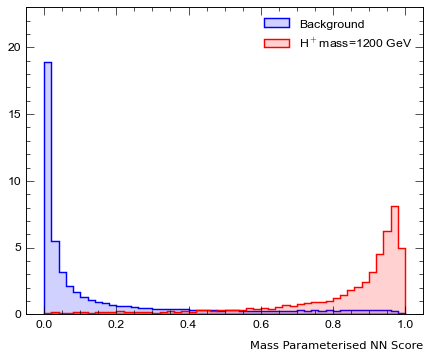

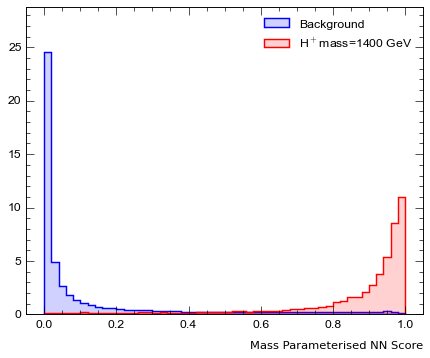

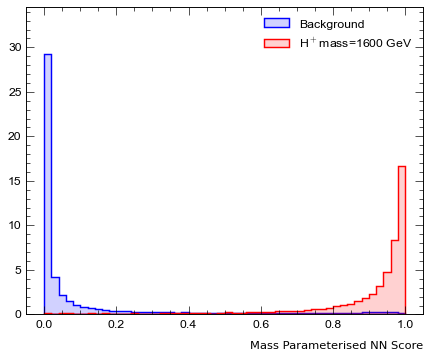

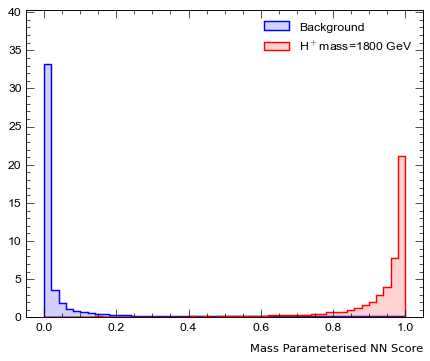

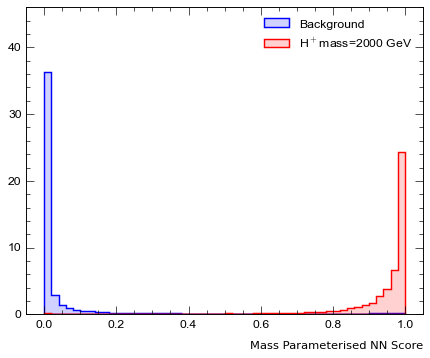

In [12]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names + ['HpDiscriminant_'+str(mass)])
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'4vec_features',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('auc_new_training.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

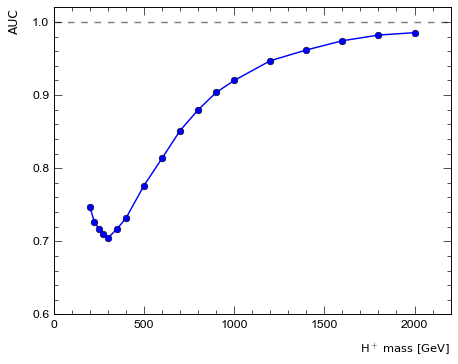

In [13]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','4vec_features')

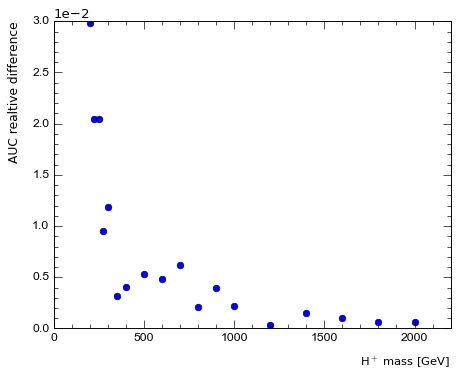

In [27]:
relativeAUC(auc_everymass[:,1],'auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','4vec_features_realtive')

In [15]:
print(auc_everymass)

[[2.00000000e+02 7.46873375e-01]
 [2.25000000e+02 7.26577296e-01]
 [2.50000000e+02 7.16925437e-01]
 [2.75000000e+02 7.09698145e-01]
 [3.00000000e+02 7.04619570e-01]
 [3.50000000e+02 7.16895726e-01]
 [4.00000000e+02 7.31647590e-01]
 [5.00000000e+02 7.76286372e-01]
 [6.00000000e+02 8.13507353e-01]
 [7.00000000e+02 8.51395122e-01]
 [8.00000000e+02 8.79755149e-01]
 [9.00000000e+02 9.03572094e-01]
 [1.00000000e+03 9.19921213e-01]
 [1.20000000e+03 9.46917015e-01]
 [1.40000000e+03 9.61638579e-01]
 [1.60000000e+03 9.74261765e-01]
 [1.80000000e+03 9.81995001e-01]
 [2.00000000e+03 9.85342835e-01]]


## New hyperparameters

In [5]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_e1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_e2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_e3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_e4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_e5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_e6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','lepton_e']
steps = ['msb','scl','rnd','wss']
region = "INC_ge6jge4b"
NNlayers = [128,128,128]
batchsize = 1024
dropout = 0.1
epochs = 300
patience = 5

In [6]:
df_new = pd.read_hdf("/nfs/at3/scratch/salvador/HplusML/HDFWriter/pandas_4vec/pandas_INC_ge6jgeq4b.h5")
df_new = df_new[(df_new.process!='Hp1001')&(df_new.process!='ttlight_aMCNloP8')&(df_new.process!='tH_new')&(df_new.weight!=0)&(df_new.hpmass!=2500)&(df_new.hpmass!=3000)]
df_new.head()

,index,dRlepbb_MindR_70,jet_eta,HpDiscriminant_275,HpNNv3_350,HpNNv3_600,HpDiscriminant_225,mu_eta,Muu_MindR_70,Mbb_MaxM_70,...,Centrality_all,HpNNv3_250,weight,ReWeighting,process,group,region,tagWeightBin_MV2c10_Continuous,hpmass,year
0,0,1.632954,"[-0.61083865, -0.38421518, 1.0957781, 0.209408...",0.628027,0.464503,0.458725,0.473889,[0.66914076],168296.703125,231522.750000,...,0.739273,0.436460,0.062751,1.017244,ttlight,t#bar{t} + light,INC_ge6jge4b,"[1, 4, 5, 4, 2, 4]",-1,mc16a
1,1,2.318960,"[-0.6561383, -0.13251838, -0.52890044, -0.1273...",0.677458,0.695016,0.305937,0.316257,[],57218.773438,200162.296875,...,0.852112,0.681223,0.136305,0.996082,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 5, 4, 4, 1, 1]",-1,mc16a
2,2,0.870068,"[2.381791, -1.3918624, 1.8041257, -1.0344955, ...",0.016884,0.098823,0.099795,0.092083,[-0.25464767],110607.484375,333937.500000,...,0.362028,0.191971,0.108638,1.010369,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 4, 1, 5, 4]",-1,mc16a
3,3,3.142407,"[0.9403318, 1.4658026, -0.07202754, 0.48571306...",0.621517,0.356497,0.042438,0.664618,[],65231.687500,186417.437500,...,0.654665,0.563828,0.112889,1.029358,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 4, 5, 4, 1]",-1,mc16a
4,4,2.089809,"[1.0356635, 2.0446057, -2.070395, 0.088136375,...",0.432156,0.172446,0.021674,0.574934,[1.4766937],448008.250000,130885.703125,...,0.388816,0.330892,0.122123,1.118524,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 1, 5, 4, 5]",-1,mc16a


In [7]:
columns_suffix= ['pt','eta','phi','e']

for s in columns_suffix:
    df_new['el_'+s]=pd.DataFrame(df_new['el_'+s].tolist(), index= df_new.index)
    df_new['mu_'+s]=pd.DataFrame(df_new['mu_'+s].tolist(), index= df_new.index)
    df_new.loc[np.isnan(df_new['el_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['el_'+s])==False]['el_'+s]
    df_new.loc[np.isnan(df_new['mu_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['mu_'+s])==False]['mu_'+s]

In [8]:
#There are some events with more than 6 components on jet_e, we cut the extra components
def jet_e_components(row):    
    ''' Function to get only the first 6 components of jet_e lists'''
    if len(row.jet_e)>6: 
        return row['jet_e'][:6]
    else: 
        return row['jet_e']
    
df_new['jet_e'] = df_new.apply (lambda row: jet_e_components(row), axis=1)

In [9]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

msb:
Background integral: 0.5 
Signal integral: 0.5 

scl:
Background integral: 0.5 
Signal integral: 0.5 

-1 1134182    3.564395e-08
63564      1.238117e-06
1376655    4.716239e-08
1116034    1.178930e-11
85513      6.783175e-07
               ...     
773653     6.509096e-07
1650183    1.653604e-07
1401201    1.947045e-08
1591320    5.042264e-08
1014801    5.554679e-07
Name: weight, Length: 973135, dtype: float64 0.5
200 1949727    0.000015
1952077    0.000011
1948948    0.000018
1949156    0.000019
1950513    0.000021
             ...   
1951659    0.000016
1951691    0.000028
1948311    0.000017
1950098    0.000018
1949061    0.000018
Name: weight, Length: 2100, dtype: float64 0.04405286343612336
225 1957651    3.388339e-06
1957494    7.660917e-06
1958522    4.776432e-06
1957951    7.743244e-06
1955832    5.695298e-06
               ...     
1954153    4.811665e-06
1956217    5.900147e-06
1956961    6.349497e-06
1958917    4.241294e-06
1958085    5.291226e-09
Name: weight, Length:

In [ ]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'new_hyperpar',region)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4736      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [ ]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'new_hyperpar')

In [ ]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names + ['HpDiscriminant_'+str(mass)])
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'new_hyperpar',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('auc_new_training_new_hyperpar.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

In [ ]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar')

In [ ]:
relativeAUC(np.array(auc_auc),'auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_relative')

In [ ]:
relativeAUC(np.array(auc_auc),'auc_new_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_4vec_comparison')

In [ ]:
print(auc_everymass)

Now we will try an intermediate NN

In [ ]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_e1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_e2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_e3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_e4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_e5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_e6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','lepton_e']
steps = ['msb','scl','rnd','wss']
region = "INC_ge6jge4b"
NNlayers = [128,128,128]
batchsize = 512
dropout = 0.1
epochs = 300
patience = 5

In [ ]:
df_new = pd.read_hdf("/nfs/at3/scratch/salvador/HplusML/HDFWriter/pandas_4vec/pandas_INC_ge6jgeq4b.h5")
df_new = df_new[(df_new.process!='Hp1001')&(df_new.process!='ttlight_aMCNloP8')&(df_new.process!='tH_new')&(df_new.weight!=0)&(df_new.hpmass!=2500)&(df_new.hpmass!=3000)]
df_new.head()

In [ ]:
columns_suffix= ['pt','eta','phi','e']

for s in columns_suffix:
    df_new['el_'+s]=pd.DataFrame(df_new['el_'+s].tolist(), index= df_new.index)
    df_new['mu_'+s]=pd.DataFrame(df_new['mu_'+s].tolist(), index= df_new.index)
    df_new.loc[np.isnan(df_new['el_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['el_'+s])==False]['el_'+s]
    df_new.loc[np.isnan(df_new['mu_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['mu_'+s])==False]['mu_'+s]

In [ ]:
#There are some events with more than 6 components on jet_e, we cut the extra components
def jet_e_components(row):    
    ''' Function to get only the first 6 components of jet_e lists'''
    if len(row.jet_e)>6: 
        return row['jet_e'][:6]
    else: 
        return row['jet_e']
    
df_new['jet_e'] = df_new.apply (lambda row: jet_e_components(row), axis=1)

In [ ]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

In [ ]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'new_hyperpar',region)

In [ ]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'new_hyperpar_512')

In [ ]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names + ['HpDiscriminant_'+str(mass)])
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass

        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'new_hyperpar_512',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('auc_new_training_new_hyperpar_512.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

In [ ]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_512')

In [ ]:
relativeAUC(np.array(auc_auc),'auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_relative_512')

In [ ]:
relativeAUC(np.array(auc_auc),'auc_new_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_4vec_comparison_512')

In [ ]:
relativeAUC(np.array(auc_auc),'auc_new_training_new_hyperpar.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','new_hyperpar_dif_batchsize_comparison')

In [ ]:
print(auc_everymass)

## Low and high level features

At this point we want to include some high level features and see how this affects to the training.

In [12]:
fpath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/arial.ttf")
fbipath = os.path.join(plt.rcParams['datapath'], "/nfs/pic.es/user/s/srodrigu/Jupyter/Fonts/ArialBoldItalic.ttf")
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = '1'
plt.rcParams['axes.linewidth']= 0.85

feature_names = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_e1', 'jet_mv2c101', 'jet_pt2', 'jet_eta2', 'jet_phi2', 'jet_e2', 'jet_mv2c102', 'jet_pt3', 'jet_eta3', 'jet_phi3', 'jet_e3', 'jet_mv2c103', 'jet_pt4', 'jet_eta4', 'jet_phi4', 'jet_e4', 'jet_mv2c104', 'jet_pt5', 'jet_eta5', 'jet_phi5', 'jet_e5', 'jet_mv2c105', 'jet_pt6', 'jet_eta6', 'jet_phi6', 'jet_e6', 'jet_mv2c106','lepton_pt','lepton_phi','lepton_eta','lepton_e','HT_jets']
exclude_columns = feature_names[:-1]
steps = ['msb','scl','rnd','fd','wss']
region = "INC_ge6jge4b"
NNlayers = [64,64]
batchsize = 50
dropout = 0.1
epochs = 300
patience = 5

In [6]:
df_new = pd.read_hdf("/nfs/at3/scratch/salvador/HplusML/HDFWriter/pandas_4vec/pandas_INC_ge6jgeq4b.h5")
df_new = df_new[(df_new.process!='Hp1001')&(df_new.process!='ttlight_aMCNloP8')&(df_new.process!='tH_new')&(df_new.weight!=0)&(df_new.hpmass!=2500)&(df_new.hpmass!=3000)]
df_new.head()

,index,dRlepbb_MindR_70,jet_eta,HpDiscriminant_275,HpNNv3_350,HpNNv3_600,HpDiscriminant_225,mu_eta,Muu_MindR_70,Mbb_MaxM_70,...,Centrality_all,HpNNv3_250,weight,ReWeighting,process,group,region,tagWeightBin_MV2c10_Continuous,hpmass,year
0,0,1.632954,"[-0.61083865, -0.38421518, 1.0957781, 0.209408...",0.628027,0.464503,0.458725,0.473889,[0.66914076],168296.703125,231522.750000,...,0.739273,0.436460,0.062751,1.017244,ttlight,t#bar{t} + light,INC_ge6jge4b,"[1, 4, 5, 4, 2, 4]",-1,mc16a
1,1,2.318960,"[-0.6561383, -0.13251838, -0.52890044, -0.1273...",0.677458,0.695016,0.305937,0.316257,[],57218.773438,200162.296875,...,0.852112,0.681223,0.136305,0.996082,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 5, 4, 4, 1, 1]",-1,mc16a
2,2,0.870068,"[2.381791, -1.3918624, 1.8041257, -1.0344955, ...",0.016884,0.098823,0.099795,0.092083,[-0.25464767],110607.484375,333937.500000,...,0.362028,0.191971,0.108638,1.010369,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 4, 1, 5, 4]",-1,mc16a
3,3,3.142407,"[0.9403318, 1.4658026, -0.07202754, 0.48571306...",0.621517,0.356497,0.042438,0.664618,[],65231.687500,186417.437500,...,0.654665,0.563828,0.112889,1.029358,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 4, 5, 4, 1]",-1,mc16a
4,4,2.089809,"[1.0356635, 2.0446057, -2.070395, 0.088136375,...",0.432156,0.172446,0.021674,0.574934,[1.4766937],448008.250000,130885.703125,...,0.388816,0.330892,0.122123,1.118524,ttlight,t#bar{t} + light,INC_ge6jge4b,"[5, 1, 1, 5, 4, 5]",-1,mc16a


In [7]:
columns_suffix= ['pt','eta','phi','e']

for s in columns_suffix:
    df_new['el_'+s]=pd.DataFrame(df_new['el_'+s].tolist(), index= df_new.index)
    df_new['mu_'+s]=pd.DataFrame(df_new['mu_'+s].tolist(), index= df_new.index)
    df_new.loc[np.isnan(df_new['el_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['el_'+s])==False]['el_'+s]
    df_new.loc[np.isnan(df_new['mu_'+s])==False,'lepton_'+s]=df_new[np.isnan(df_new['mu_'+s])==False]['mu_'+s]

In [8]:
#There are some events with more than 6 components on jet_e, we cut the extra components
def jet_e_components(row):    
    ''' Function to get only the first 6 components of jet_e lists'''
    if len(row.jet_e)>6: 
        return row['jet_e'][:6]
    else: 
        return row['jet_e']
    
df_new['jet_e'] = df_new.apply (lambda row: jet_e_components(row), axis=1)

In [13]:
data = PrepareMassParametrised(df_new, feature_names, steps_names=steps, exclude_columns=exclude_columns)
X_train, y_train, w_train = data[0]
X_test, y_test, w_test = data[1]
wss_fit = data[2]

msb:
Background integral: 0.5 
Signal integral: 0.5 

scl:
Background integral: 0.5 
Signal integral: 0.5 

-1 1134182    3.564395e-08
63564      1.238117e-06
1376655    4.716239e-08
1116034    1.178930e-11
85513      6.783175e-07
               ...     
773653     6.509096e-07
1650183    1.653604e-07
1401201    1.947045e-08
1591320    5.042264e-08
1014801    5.554679e-07
Name: weight, Length: 973135, dtype: float64 0.5
200 1949727    0.000015
1952077    0.000011
1948948    0.000018
1949156    0.000019
1950513    0.000021
             ...   
1951659    0.000016
1951691    0.000028
1948311    0.000017
1950098    0.000018
1949061    0.000018
Name: weight, Length: 2100, dtype: float64 0.04405286343612336
225 1957651    3.388339e-06
1957494    7.660917e-06
1958522    4.776432e-06
1957951    7.743244e-06
1955832    5.695298e-06
               ...     
1954153    4.811665e-06
1956217    5.900147e-06
1956961    6.349497e-06
1958917    4.241294e-06
1958085    5.291226e-09
Name: weight, Length:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2560      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
21740/21740 [==============================] - 128s 6ms/step - loss: 4.2604e-07 - binary_accuracy: 0.7244 - 

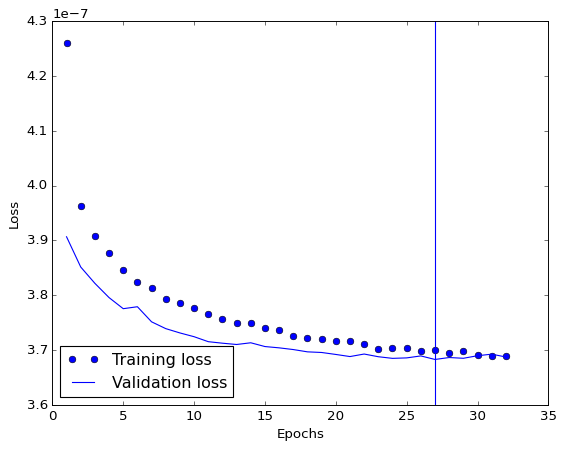

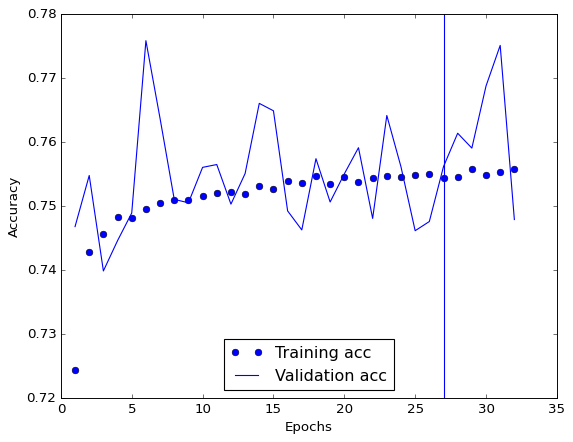

In [15]:
modelNN = training((X_train, y_train, w_train),(X_test, y_test, w_test),NNlayers,dropout,epochs,patience,batchsize,'low_features_HTjets',region)

0.8926864385612345

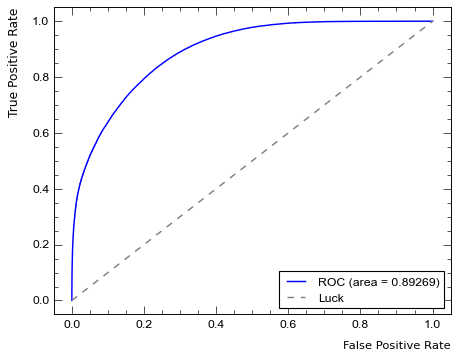

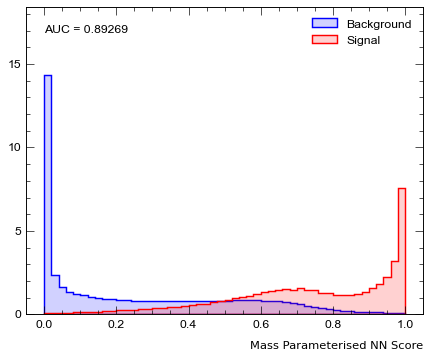

In [16]:
ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'lowlvl_features_HTjets')

(977067, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(978810, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980083, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980617, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(981324, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980383, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980821, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
(980204, 39) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 1

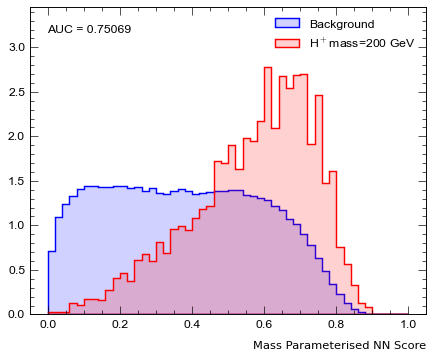

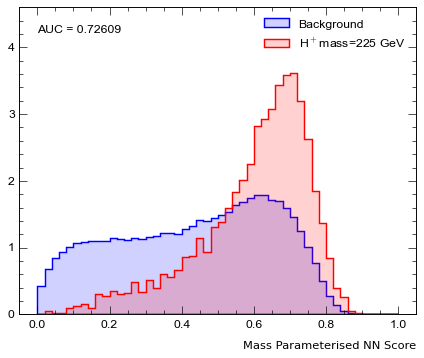

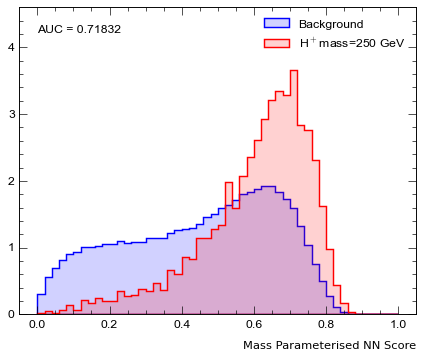

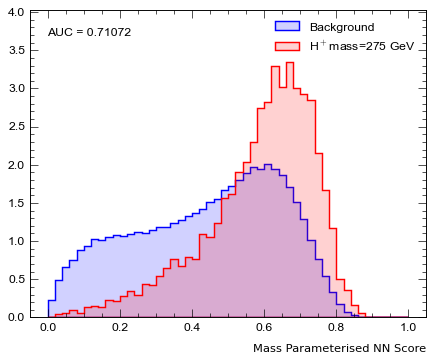

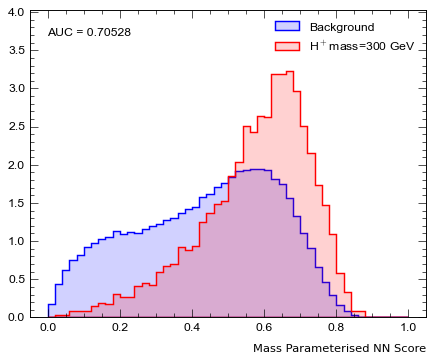

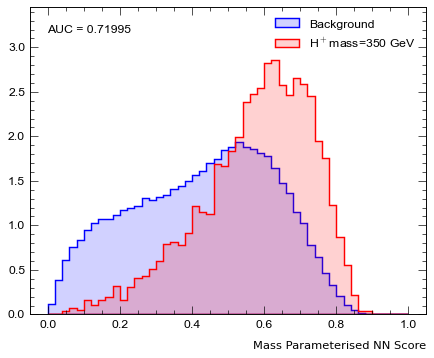

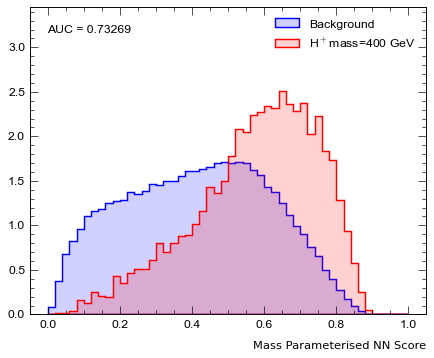

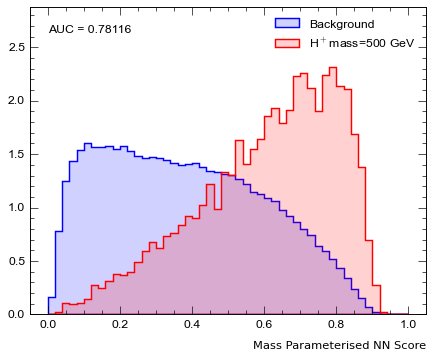

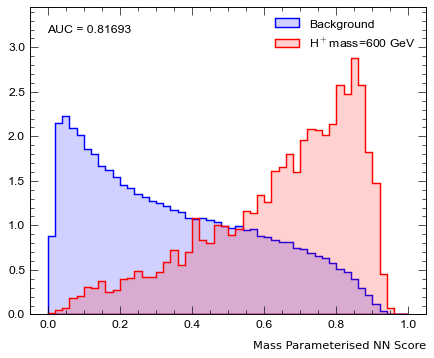

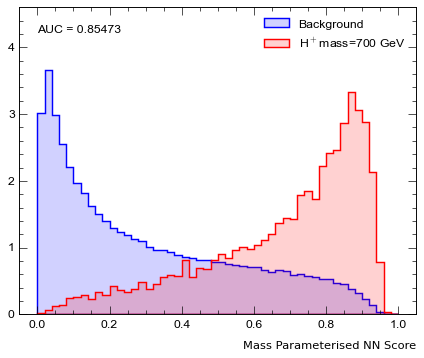

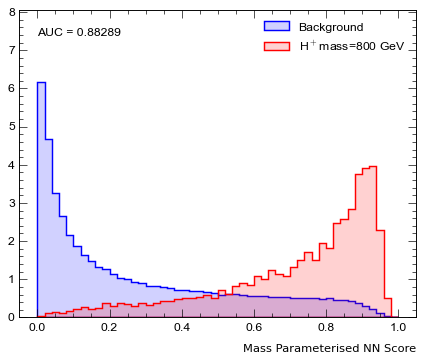

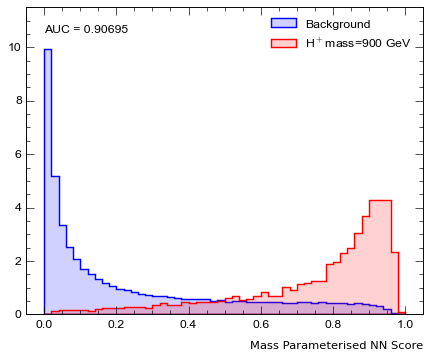

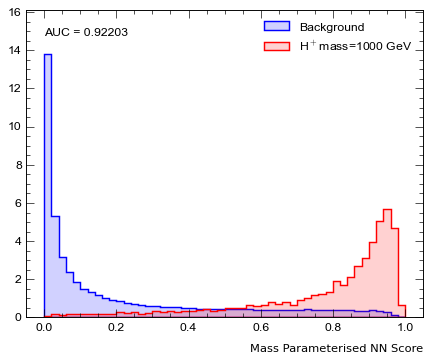

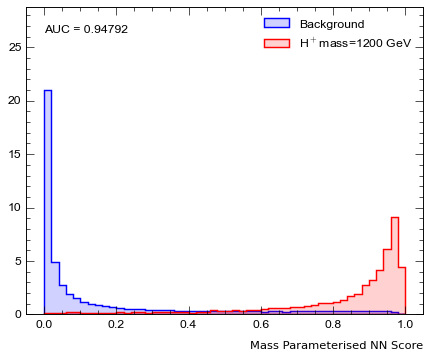

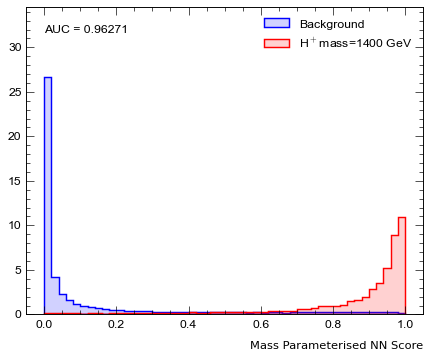

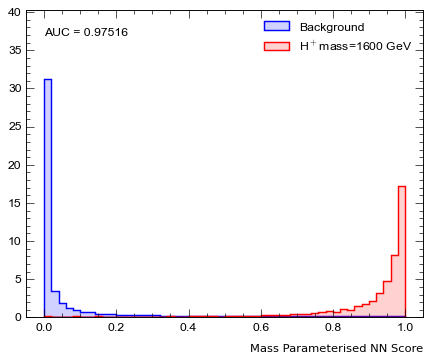

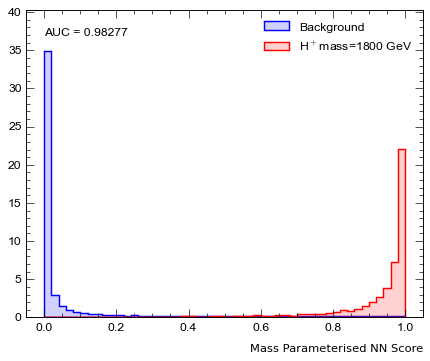

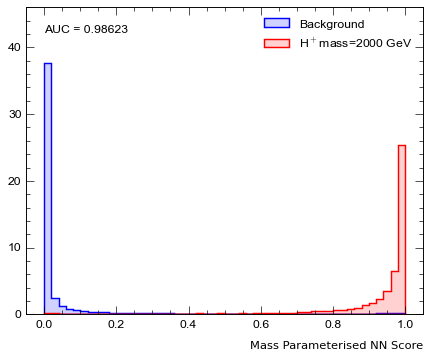

In [19]:
auc_everymass=[]

for mass in list(df_new.hpmass.unique()):
    if mass!=-1:
        htf = HpTrainingFrame.HpTrainingFrame(df_new,feature_names + ['HpDiscriminant_'+str(mass)])
        fd = FeatureDivider("hpmass",excludecolumns = exclude_columns)
        wss = WeightedStandardScaler()
        
        wss.mean_ = wss_fit[0]
        wss.scale_= wss_fit[1]

        X_train, X_test, X_eval, y_train, y_test, y_eval, w_train, w_test, w_eval = htf.prepare(hpmass=str(mass),region=region,addMass=True)
        X_test['hpmass'] = mass
        
        X_test, y_test, w_test = fd.transform(X_test,y_test, sample_weight=w_test)
        X_test, y_test, w_test = wss.transform(X_test,y_test, sample_weight=w_test)
        
        auc = ROC_Score_plot(modelNN,X_test,y_test,w_test,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training',region,'lowlvl_features_HTjets',hpmass=mass,do_ROC=False)
        auc_everymass.append([mass,auc])

auc_everymass = np.array(auc_everymass)
auc_mass = auc_everymass[:,0]
auc_auc = auc_everymass[:,1]

with open('auc_lowlvl_features_HTjets.json','w') as outputFile:
    json.dump({'Hp mass':list(auc_mass), 'AUC':list(auc_auc)}, outputFile, sort_keys=True)

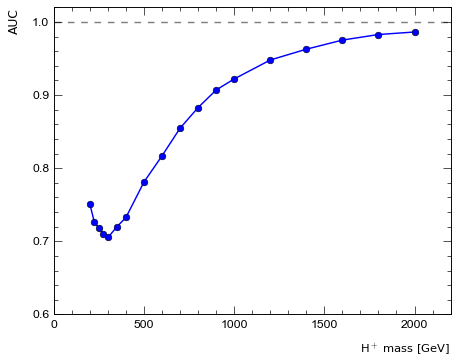

In [20]:
AUCvsHpmass(auc_auc,auc_mass,region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','lowlvl_features_HTjets')

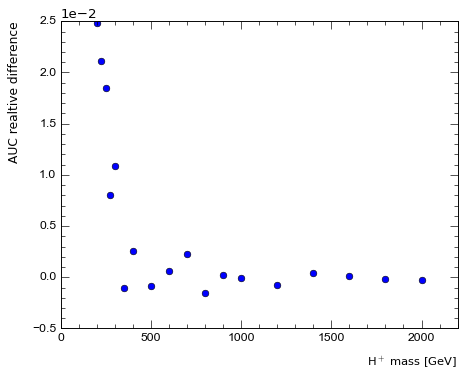

In [21]:
relativeAUC(auc_everymass[:,1],'auc_actual_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','lowlvl_features_HTjets_realtive')

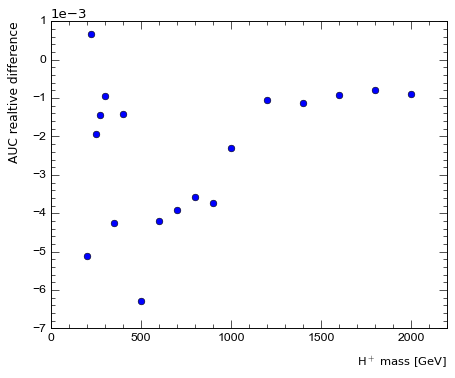

In [22]:
relativeAUC(np.array(auc_auc),'auc_new_training.json',region,'/nfs/pic.es/user/s/srodrigu/Jupyter/Machine_learning/NN_sergio_results/new_training','HT_jets_4vec_comparison')

## Symmetry review

Now we will apply some transformations to _phi_ and _eta_ variables in order to take into account the symmetries of the CERN collider so de NN doesn't has to.